## Basic Pipeline Example

This notebook shows how to use basic functions of the Cortex Python SDK pipeline. 
In this example, see how to modify or enrich datasets to make them suitable for training or modeling. 
Data is modified in a sequential series of steps.

In [5]:
# Import Cortex and other required libraries
import math
import numpy as np
import pandas as pd
from cortex import Cortex

# Create a Builder instance
cortex = Cortex.local()
builder = cortex.builder()

ImportError: cannot import name 'Cortex' from 'cortex' (unknown location)

In the next step, create a data set and populate it from a comma separated values file. A pipeline operates on a dataset.

In [4]:
!pip install cortex-client==7.0.0

In [2]:
data_set = builder.dataset('forest_fires').title('Forest Fire Data')\
    .from_csv('data/ff.sample.csv').build()
# Create a pandas DataFrame to view the last few lines of the dataset
data_frame = data_set.as_pandas()
data_frame.tail(20)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.00
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.00
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.00
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.00
9,3,4,sep,fri,93.3,141.2,713.9,13.9,18.6,49,3.6,0.0,35.88


**validate types**

We need to make sure that the types in the columns are what we are expecting.

In [3]:
print(data_frame.dtypes)

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object


In [4]:
def draw_graphs(data_set, data_frame, attribute):

    v = data_set.visuals(data_frame)
    v.show_corr_heatmap()
    v.show_corr(attribute)
    v.show_corr_pairs(attribute)
    v.show_dist(attribute)
    v.show_probplot(attribute)

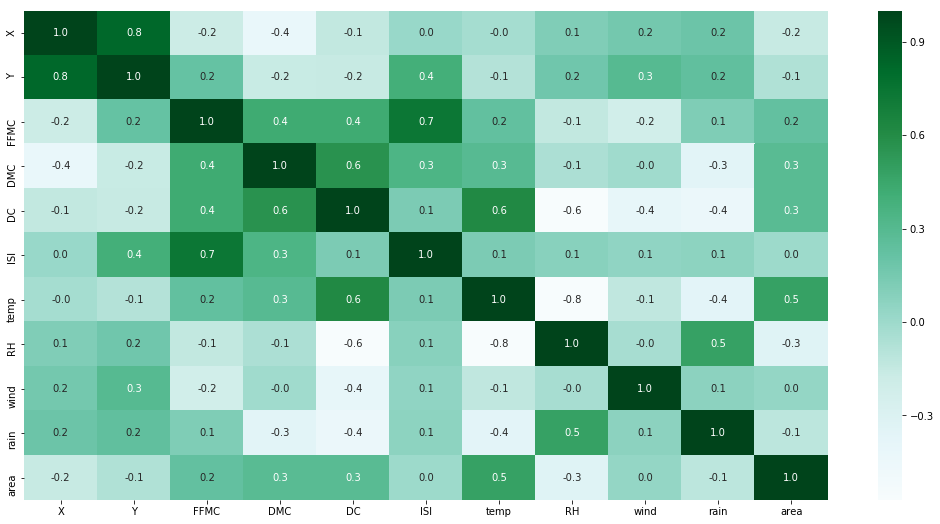

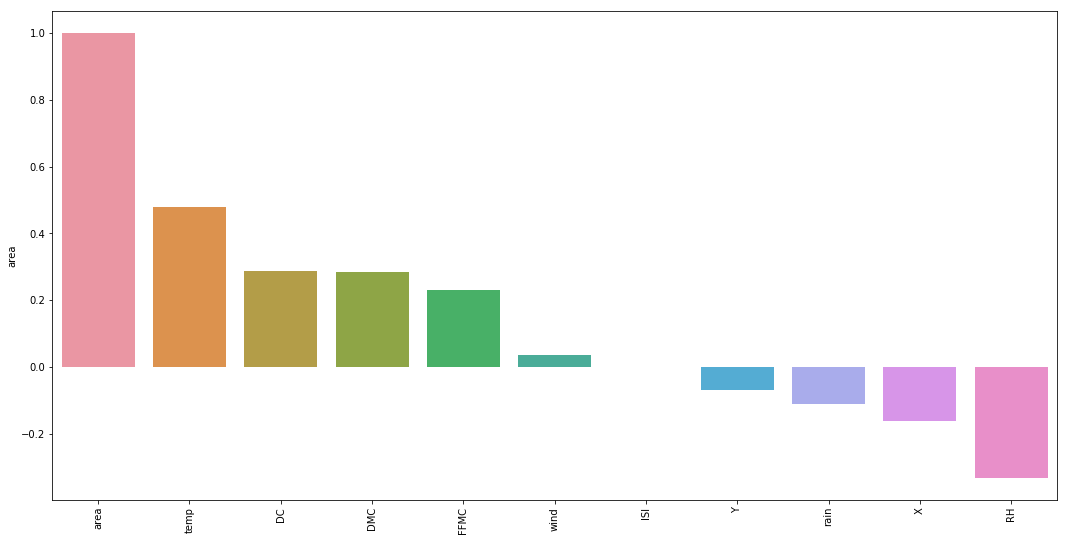

<Figure size 1296x648 with 0 Axes>

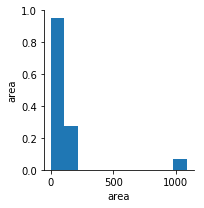

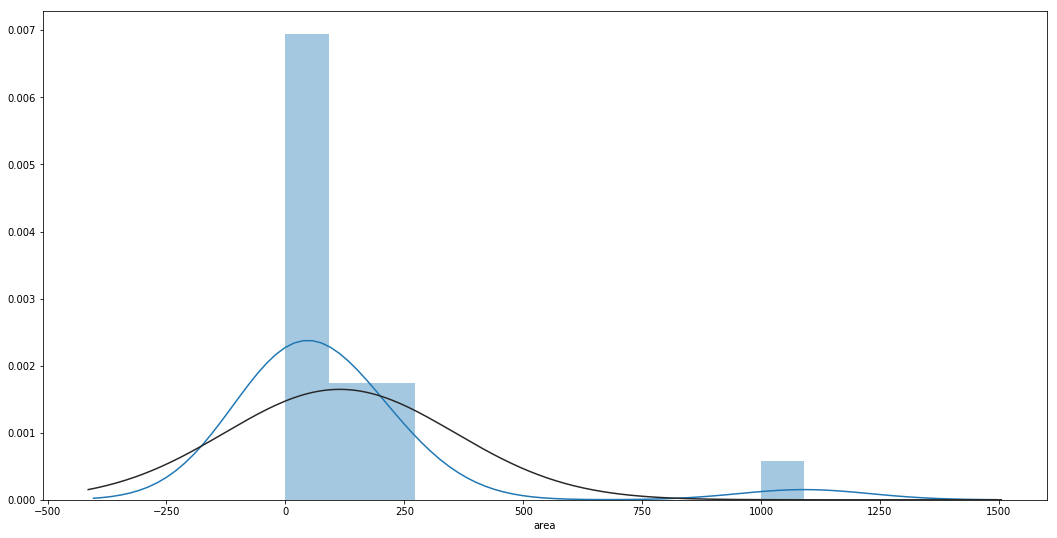

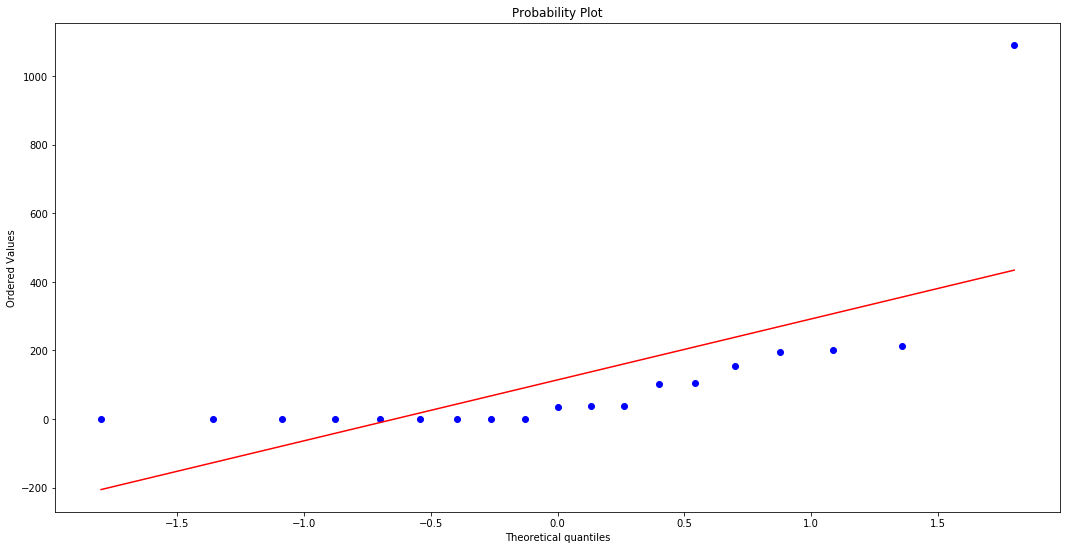

<Figure size 1296x648 with 0 Axes>

In [5]:
draw_graphs(data_set, data_frame, 'area')

A dataset can have one or more named pipelines. Each pipeline is a chain of Python functions that transform the dataset.  In the next step, create a pipeline named "prep".

In [6]:
pipeline = data_set.pipeline('prep') # create or retrieve the pipline named 'prep'
pipeline.reset() # removes any previous steps or context for this pipeline

One pipeline step can be used to add a new column.

This [dataset](http://piano.dsi.uminho.pt/~pcortez/fires.pdf) uses components from the Fire Weather Index to make predictions. One element, the Build Up Index (BUI) is based on a relation of two other columns and is omitted. This step adds that missing element. 

In [7]:
def normalize(pipeline, df):
    cols = ["DMC", "DC", "area"]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

pipeline.add_step(normalize)

In [130]:
def add_bui(pipeline, df):
    df['BUI'] = (0.8 * df['DMC'] * df['DC'])/(df['DMC'] + 0.4 * df['DC'])

pipeline.add_step(add_bui)

In the preceeding code, the pipeline step functions require a pipeline and a dataframe parameter. The [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) provides a rich set of functions for operating on table data.

A pipeline step may be used to modify a column.

The dataset's documentation says that the last column, __area__, is skewed towards zero and should be adjusted logarithmically "to improve regression results for right-skewed targets".

In [131]:
def fix_area(pipeline, df):
    df['area'] = df['area'].map(lambda a: math.log1p(a))
    
pipeline.add_step(fix_area)

### Running the Pipeline
After all the steps are added, you can call `run` on the pipeline. This invokes each of the steps in order and returns a transformed DataFrame instance.

In [134]:
data_frame = pipeline.run(data_frame)

running pipeline [prep]:
> normalize 
> add_bui 
> fix_area 


In [136]:
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [133]:
data_frame.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
BUI      float64
dtype: object

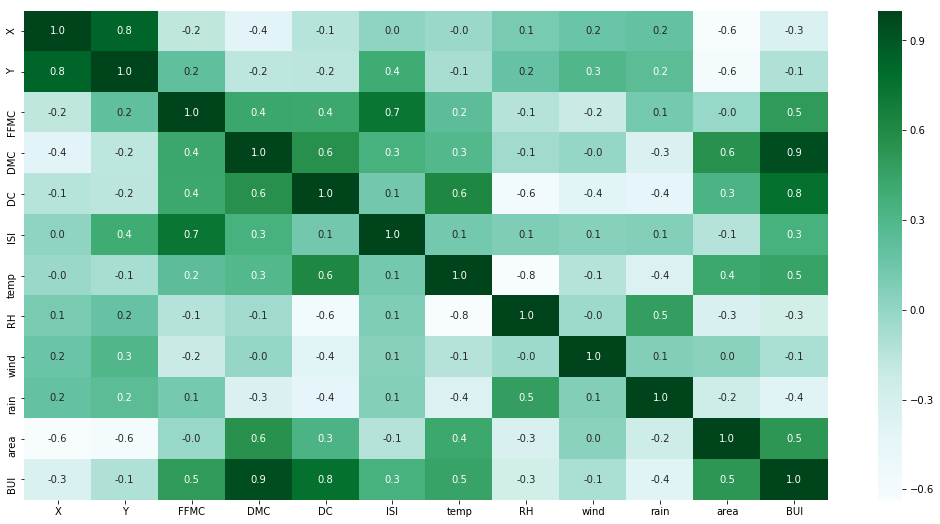

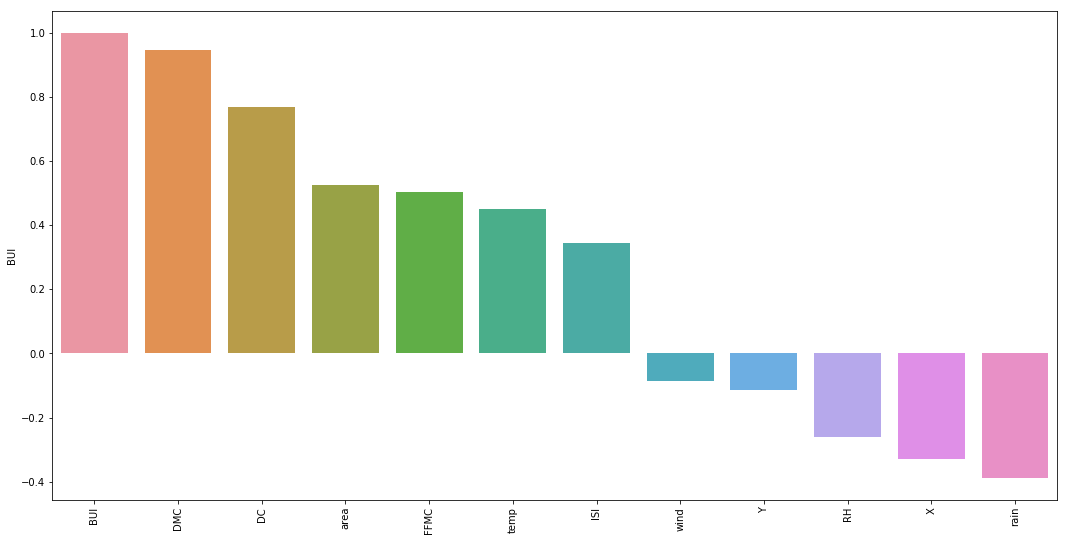

<Figure size 1296x648 with 0 Axes>

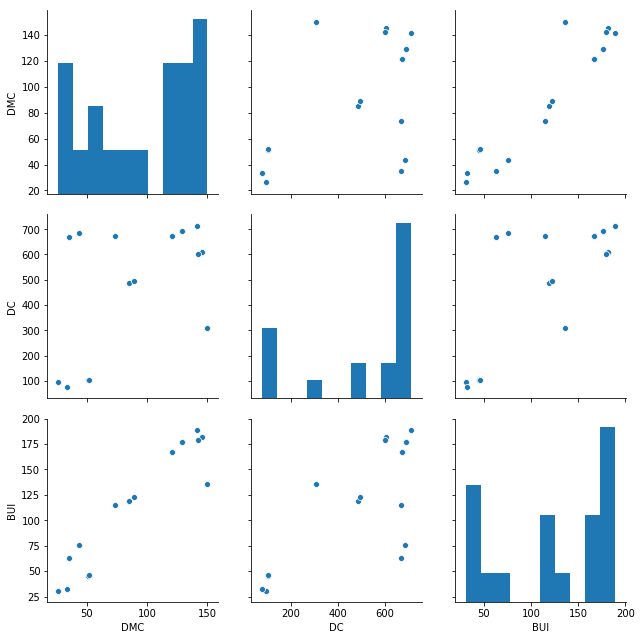

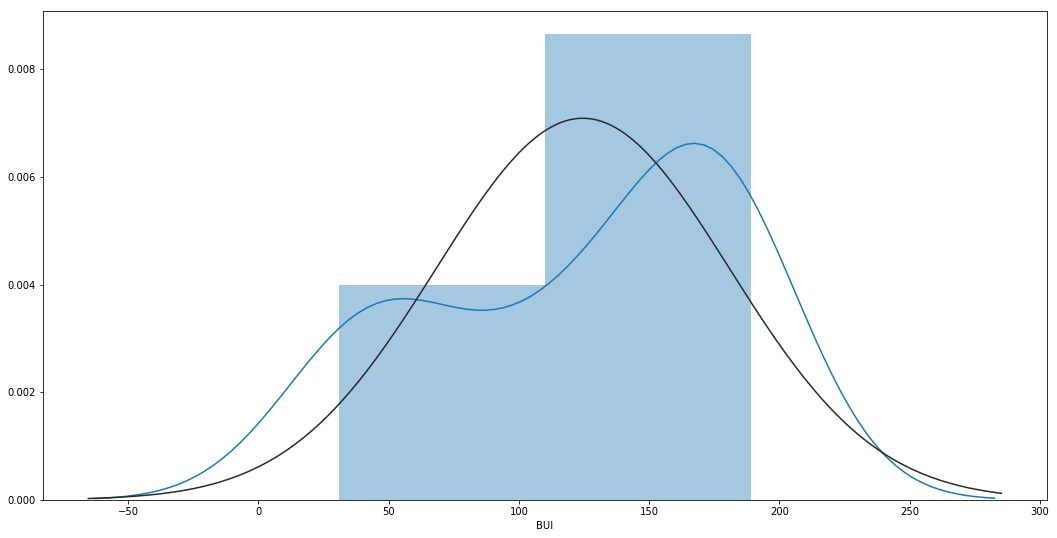

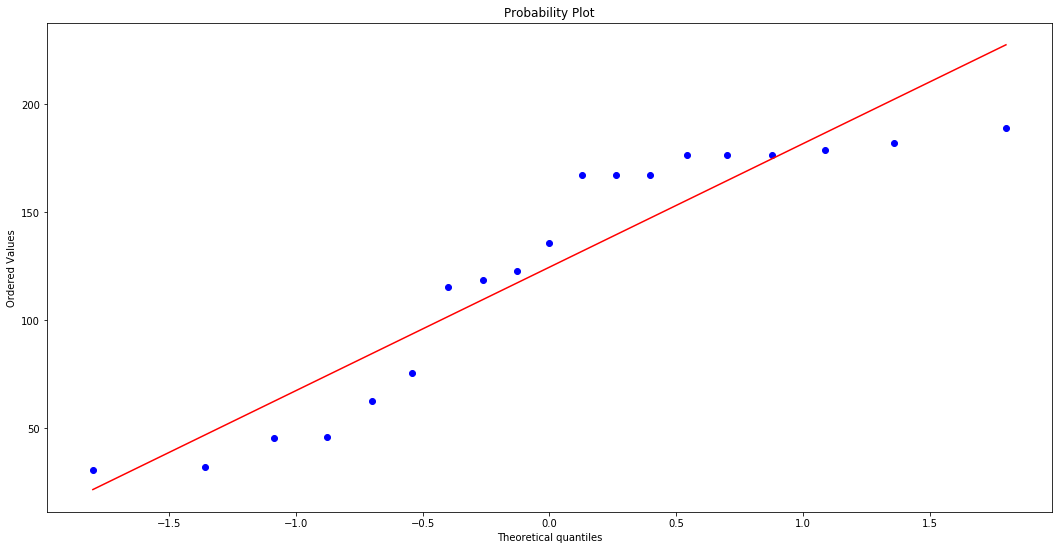

<Figure size 1296x648 with 0 Axes>

In [141]:
draw_graphs(data_set, data_frame, 'BUI')

Lets save our pipeline for later use

In [36]:
pipeline.to_camel()

{'name': 'prep',
 'steps': [{'name': 'add_bui',
   'function': {'name': 'add_bui',
    'code': 'gANjZGlsbC5fZGlsbApfY3JlYXRlX2Z1bmN0aW9uCnEAKGNkaWxsLl9kaWxsCl9sb2FkX3R5cGUKcQFYCAAAAENvZGVUeXBlcQKFcQNScQQoSwJLAEsCSwVLQ0MwZAF8AWQCGQAUAHwBZAMZABQAfAFkAhkAZAR8AWQDGQAUABcAGwB8AWQFPABkAFMAcQUoTkc/6ZmZmZmZmlgDAAAARE1DcQZYAgAAAERDcQdHP9mZmZmZmZpYAwAAAEJVSXEIdHEJKVgIAAAAcGlwZWxpbmVxClgCAAAAZGZxC4ZxDFgfAAAAPGlweXRob24taW5wdXQtMjYtYzFkY2ZhYTIzOTUwPnENWAcAAABhZGRfYnVpcQ5LAUMCAAFxDykpdHEQUnERfXESaA5OTn1xE3RxFFJxFS4=',
    'type': 'inline'}},
  {'name': 'fix_area',
   'function': {'name': 'fix_area',
    'code': 'gANjZGlsbC5fZGlsbApfY3JlYXRlX2Z1bmN0aW9uCnEAKGNkaWxsLl9kaWxsCl9sb2FkX3R5cGUKcQFYCAAAAENvZGVUeXBlcQKFcQNScQQoSwJLAEsCSwRLQ0MafAFkARkAoABkAmQDhAChAXwBZAE8AGQAUwBxBShOWAQAAABhcmVhcQZoBChLAUsASwFLA0tTQwp0AKABfAChAVMAcQdOhXEIWAQAAABtYXRocQlYBQAAAGxvZzFwcQqGcQtYAQAAAGFxDIVxDVgfAAAAPGlweXRob24taW5wdXQtMjctODgyOTFkMWU1NzgwPnEOWAgAAAA8bGFtYmRhPnEPSwJDAHEQKSl0cRFScRJYGgAAAGZpeF9hcmVhLjxsb2NhbHM+LjxsY

In [39]:
data_set.save()

**Break point**

We have added metadata to our local sample dataset, now we want to use this pipeline on the full dataset and move it to cortex remote

In [42]:
# Create a non-local Builder instance
from cortex.builder.dataset_builder import DatasetBuilder
cortex = Cortex.client()
builder = cortex.builder()

In [44]:
# to help with making this dataset distinct in class we will use an input generator here for the dataset name.  
# This variable will be stored throughout this example.
dataset_forestfire = input("namespace/dataset name")
    


#csv_example_data_set = csv_data_set_builder.from_csv('./data/sample_large.csv').build()

namespace/dataset name luketest/remote_dataset


We'll take a look at the pipeline camel spec here



In [52]:
pipeline.to_camel()

{'name': 'prep',
 'steps': [{'name': 'add_bui',
   'function': {'name': 'add_bui',
    'code': 'gANjZGlsbC5fZGlsbApfY3JlYXRlX2Z1bmN0aW9uCnEAKGNkaWxsLl9kaWxsCl9sb2FkX3R5cGUKcQFYCAAAAENvZGVUeXBlcQKFcQNScQQoSwJLAEsCSwVLQ0MwZAF8AWQCGQAUAHwBZAMZABQAfAFkAhkAZAR8AWQDGQAUABcAGwB8AWQFPABkAFMAcQUoTkc/6ZmZmZmZmlgDAAAARE1DcQZYAgAAAERDcQdHP9mZmZmZmZpYAwAAAEJVSXEIdHEJKVgIAAAAcGlwZWxpbmVxClgCAAAAZGZxC4ZxDFgfAAAAPGlweXRob24taW5wdXQtMjYtYzFkY2ZhYTIzOTUwPnENWAcAAABhZGRfYnVpcQ5LAUMCAAFxDykpdHEQUnERfXESaA5OTn1xE3RxFFJxFS4=',
    'type': 'inline'}},
  {'name': 'fix_area',
   'function': {'name': 'fix_area',
    'code': 'gANjZGlsbC5fZGlsbApfY3JlYXRlX2Z1bmN0aW9uCnEAKGNkaWxsLl9kaWxsCl9sb2FkX3R5cGUKcQFYCAAAAENvZGVUeXBlcQKFcQNScQQoSwJLAEsCSwRLQ0MafAFkARkAoABkAmQDhAChAXwBZAE8AGQAUwBxBShOWAQAAABhcmVhcQZoBChLAUsASwFLA0tTQwp0AKABfAChAVMAcQdOhXEIWAQAAABtYXRocQlYBQAAAGxvZzFwcQqGcQtYAQAAAGFxDIVxDVgfAAAAPGlweXRob24taW5wdXQtMjctODgyOTFkMWU1NzgwPnEOWAgAAAA8bGFtYmRhPnEPSwJDAHEQKSl0cRFScRJYGgAAAGZpeF9hcmVhLjxsb2NhbHM+LjxsY

In [78]:
data_set = builder.dataset(dataset_forestfire).title('Forest Fire Data')\
    .from_csv('data/forestfires.csv').build()
# Create a pandas DataFrame to view the last few lines of the dataset
data_frame = data_set.as_pandas()
data_frame.tail(20)

file version not found, pushing to remote storage: /cortex/datasets/luketest/remote_dataset/88033b31625bdfd968d85ea99585196f.csv


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
497,3,4,aug,tue,96.1,181.1,671.2,14.3,32.3,27,2.2,0.0,14.68
498,6,5,aug,tue,96.1,181.1,671.2,14.3,33.3,26,2.7,0.0,40.54
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.0
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.0
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.0
503,2,4,aug,wed,94.5,139.4,689.1,20.0,29.2,30,4.9,0.0,1.95
504,4,3,aug,wed,94.5,139.4,689.1,20.0,28.9,29,4.9,0.0,49.59
505,1,2,aug,thu,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,5.8
506,1,2,aug,fri,91.0,166.9,752.6,7.1,18.5,73,8.5,0.0,0.0


In [82]:
print(pipeline)

In [83]:
remote_pipeline = data_set.pipeline('prep') # create or retrieve the pipline named 'prep'
remote_pipeline.from_pipeline(pipeline)
#pipeline.reset() # removes any previous steps or context for this pipeline

In [85]:
remote_pipeline.run(data_frame)

running pipeline [prep]:
> add_bui 


TypeError: can't multiply sequence by non-int of type 'float'